## Data Loading and Preparation

### Subtask:
Load datasets, aggregate daily sales to monthly level, add metadata, create lag features, and clean the data.


**Reasoning**:
Import necessary libraries and check if the required dataset files exist in the working directory before loading them.



In [16]:
import pandas as pd
import numpy as np
import os

# 1. Check files
required_files = [
    'sales_train.csv', 'test.csv', 'items.csv',
    'item_categories.csv', 'shops.csv'
]

missing_files = [f for f in required_files if not os.path.exists(f)]

if missing_files:
    print(f"MISSING FILES: {missing_files}")
    print("Please upload them to the current directory.")
else:
    print("All required files are present.")

All required files are present.


**Reasoning**:
Load the datasets into pandas DataFrames and display their dimensions and first few rows to ensure they are loaded correctly before proceeding with analysis.



In [17]:
import pandas as pd

# Load datasets
sales_train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')
items = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

# Print shapes and heads
datasets = [
    ('sales_train', sales_train),
    ('test', test),
    ('items', items),
    ('item_categories', item_categories),
    ('shops', shops)
]

for name, df in datasets:
    print(f"--- {name} ---")
    print(f"Shape: {df.shape}")
    print(df.head())
    print("\n")

--- sales_train ---
Shape: (2935849, 6)
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0


--- test ---
Shape: (214200, 3)
   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268


--- items ---
Shape: (22170, 3)
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)               

**Reasoning**:
Perform data aggregation on sales_train to create monthly sales data. Clip the target value to [0, 20]. Merge item categories. Create lag features using groupby and shift as requested (sorting first to ensure order). Drop NaNs produced by lag generation. This prepares the final training dataframe.



In [18]:
import pandas as pd
import numpy as np

# 1. Aggregate to monthly level
# Group by date_block_num, shop_id, item_id
monthly_sales = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg(
    item_cnt_month=('item_cnt_day', 'sum'),
    item_price_avg=('item_price', 'mean')
).reset_index()

# 2. Clip item_cnt_month to [0, 20]
monthly_sales['item_cnt_month'] = monthly_sales['item_cnt_month'].clip(0, 20)

# 3. Join metadata (item_category_id)
# We only need item_category_id from items
monthly_sales = pd.merge(monthly_sales, items[['item_id', 'item_category_id']], on='item_id', how='left')

# 4. Create simple lag features
# Sort first to ensure lags are chronological
monthly_sales = monthly_sales.sort_values(['shop_id', 'item_id', 'date_block_num'])

for i in [1, 2, 3]:
    col_name = f'item_cnt_lag_{i}'
    monthly_sales[col_name] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(i)

# 5. Drop rows with NaN lag features
# This effectively removes the first few months for each item/shop and unconnected periods
monthly_sales_clean = monthly_sales.dropna()

# 6. Print final shape and columns
print(f"Final Modeling Table Shape: {monthly_sales_clean.shape}")
print(f"Columns: {monthly_sales_clean.columns.tolist()}")
print(monthly_sales_clean.head())

Final Modeling Table Shape: (711141, 9)
Columns: ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_price_avg', 'item_category_id', 'item_cnt_lag_1', 'item_cnt_lag_2', 'item_cnt_lag_3']
         date_block_num  shop_id  item_id  item_cnt_month  item_price_avg  \
882779               16        2       30             1.0          169.00   
882780               16        2       31             1.0          415.92   
1577593              33        2       31             1.0          399.00   
1067221              20        2       32             2.0          149.00   
1107644              21        2       32             2.0          149.00   

         item_category_id  item_cnt_lag_1  item_cnt_lag_2  item_cnt_lag_3  
882779                 40             1.0             1.0             1.0  
882780                 37             1.0             1.0             4.0  
1577593                37             1.0             1.0             1.0  
1067221                40        

## Train/Validation Split and Baseline Model

### Subtask:
Perform a time-based train/validation split and evaluate a simple baseline model using lag features.


**Reasoning**:
Perform time-based train/validation split and evaluate a baseline model using the previous month's sales as the prediction.



In [19]:
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Time-based split
train = monthly_sales_clean[monthly_sales_clean['date_block_num'] <= 31]
val = monthly_sales_clean[monthly_sales_clean['date_block_num'].isin([32, 33])]

print(f"Train set shape: {train.shape}")
print(f"Validation set shape: {val.shape}")

# 2. Define features and target
features = [
    'date_block_num', 'shop_id', 'item_id', 'item_category_id',
    'item_price_avg', 'item_cnt_lag_1', 'item_cnt_lag_2', 'item_cnt_lag_3'
]
target = 'item_cnt_month'

# 3. Create feature matrices and target vectors
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

# 4. Baseline Model: Predict validation target using the last lag (item_cnt_lag_1)
y_pred_baseline = X_val['item_cnt_lag_1']

# 5. Calculate RMSE
rmse_baseline = np.sqrt(mean_squared_error(y_val, y_pred_baseline))
print(f"Baseline RMSE on Validation Set: {rmse_baseline:.4f}")

Train set shape: (675441, 9)
Validation set shape: (35700, 9)
X_train shape: (675441, 8)
X_val shape: (35700, 8)
Baseline RMSE on Validation Set: 1.7962


## Train Main Model

### Subtask:
Train an XGBoost regressor and evaluate RMSE on training and validation sets.


**Reasoning**:
Train an XGBoost regressor using the specified hyperparameters and evaluate its performance by calculating RMSE on both the training and validation sets.



In [20]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Instantiate the model
xgb_model = XGBRegressor(
    max_depth=8,
    n_estimators=50,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1  # Use all cores
)

# 2. Fit the model
print("Training XGBoost model...")
xgb_model.fit(X_train, y_train)

# 3. Predict
y_pred_train = xgb_model.predict(X_train)
y_pred_val = xgb_model.predict(X_val)

# 4. Compute RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

# 5. Print results
print(f"XGBoost RMSE on Train Set: {rmse_train:.4f}")
print(f"XGBoost RMSE on Validation Set: {rmse_val:.4f}")

Training XGBoost model...
XGBoost RMSE on Train Set: 1.5090
XGBoost RMSE on Validation Set: 1.4736


## Calculate Evaluation Metrics

### Subtask:
Compute AUC and AIR metrics for training and validation sets as required by the project rubric.


**Reasoning**:
Calculate AUC and AIR metrics for both training and validation sets as required by the rubric. This involves binarizing the target variable for AUC and calculating selection rates across item categories for AIR.



In [21]:
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

# 1. Create binary targets (1 if sales > 0, else 0)
y_train_bin = (y_train > 0).astype(int)
y_val_bin = (y_val > 0).astype(int)

# 2. Compute ROC AUC
# We use the regression predictions as the score/probability proxy
auc_train = roc_auc_score(y_train_bin, y_pred_train)
auc_val = roc_auc_score(y_val_bin, y_pred_val)

print(f"TRAIN AUC: {auc_train:.4f}")
print(f"VALIDATION AUC: {auc_val:.4f}")

# 3. Compute AIR (Adverse Impact Ratio)
# Grouping by item_category_id
# Positive decision = prediction > 0.5 (predicting at least ~1 sale)

def compute_air(X_df, y_pred_arr, group_col='item_category_id'):
    temp_df = X_df.copy()
    temp_df['predicted_positive'] = (y_pred_arr > 0.5).astype(int)

    # Calculate positive rate per group
    group_rates = temp_df.groupby(group_col)['predicted_positive'].mean()

    # Filter out groups with no samples if any (though merge logic handles this)
    # Compute AIR: min rate / max rate
    min_rate = group_rates.min()
    max_rate = group_rates.max()

    if max_rate == 0:
        return 0.0
    return min_rate / max_rate

air_train = compute_air(X_train, y_pred_train)
air_val = compute_air(X_val, y_pred_val)

print(f"TRAIN AIR: {air_train:.4f}")
print(f"VALIDATION AIR: {air_val:.4f}")

TRAIN AUC: 0.5580
VALIDATION AUC: 0.5189
TRAIN AIR: 1.0000
VALIDATION AIR: 1.0000


## Generate Predictions for Test Set

### Subtask:
Prepare the test dataset with necessary features (lags, metadata) and generate predictions using the trained XGBoost model.


**Reasoning**:
Prepare the test dataset by adding necessary features (metadata, price, lags) derived from the training data, handle missing values, generate predictions using the trained XGBoost model, clip the results, and save the submission file.



In [22]:
# 1. Prepare test dataframe
test_prepared = test.copy()
test_prepared['date_block_num'] = 34

# 2. Merge metadata
test_prepared = pd.merge(test_prepared, items[['item_id', 'item_category_id']], on='item_id', how='left')

# 3. Create lag features manually for test set
# We need to pull data from previous months in monthly_sales

# lag_1 (and price) from block 33
block33 = monthly_sales[monthly_sales['date_block_num'] == 33][['shop_id', 'item_id', 'item_cnt_month', 'item_price_avg']]
test_prepared = pd.merge(test_prepared, block33, on=['shop_id', 'item_id'], how='left')
test_prepared.rename(columns={'item_cnt_month': 'item_cnt_lag_1'}, inplace=True)

# lag_2 from block 32
block32 = monthly_sales[monthly_sales['date_block_num'] == 32][['shop_id', 'item_id', 'item_cnt_month']]
test_prepared = pd.merge(test_prepared, block32, on=['shop_id', 'item_id'], how='left')
test_prepared.rename(columns={'item_cnt_month': 'item_cnt_lag_2'}, inplace=True)

# lag_3 from block 31
block31 = monthly_sales[monthly_sales['date_block_num'] == 31][['shop_id', 'item_id', 'item_cnt_month']]
test_prepared = pd.merge(test_prepared, block31, on=['shop_id', 'item_id'], how='left')
test_prepared.rename(columns={'item_cnt_month': 'item_cnt_lag_3'}, inplace=True)

# 4. Handle missing values
lag_cols = ['item_cnt_lag_1', 'item_cnt_lag_2', 'item_cnt_lag_3']
test_prepared[lag_cols] = test_prepared[lag_cols].fillna(0)

# Fill missing price with overall mean
mean_price = monthly_sales['item_price_avg'].mean()
test_prepared['item_price_avg'] = test_prepared['item_price_avg'].fillna(mean_price)

# 5. Select columns
features = ['date_block_num', 'shop_id', 'item_id', 'item_category_id', 'item_price_avg', 'item_cnt_lag_1', 'item_cnt_lag_2', 'item_cnt_lag_3']
X_test = test_prepared[features]

# 6. Predict
y_test_pred = xgb_model.predict(X_test)

# 7. Clip
y_test_pred = y_test_pred.clip(0, 20)

# 8. Create submission
submission = pd.DataFrame({
    'ID': test_prepared['ID'],
    'item_cnt_month': y_test_pred
})

# 9. Save
submission.to_csv('submission.csv', index=False)

# 10. Print
print("Submission shape:", submission.shape)
print(submission.head())

Submission shape: (214200, 2)
   ID  item_cnt_month
0   0        1.870471
1   1        1.160404
2   2        1.580862
3   3        1.570323
4   4        1.668505


**Reasoning**:
Generate and save the required plots: total monthly sales over time and feature importance from the XGBoost model. This satisfies the visualization requirement of the project rubric.



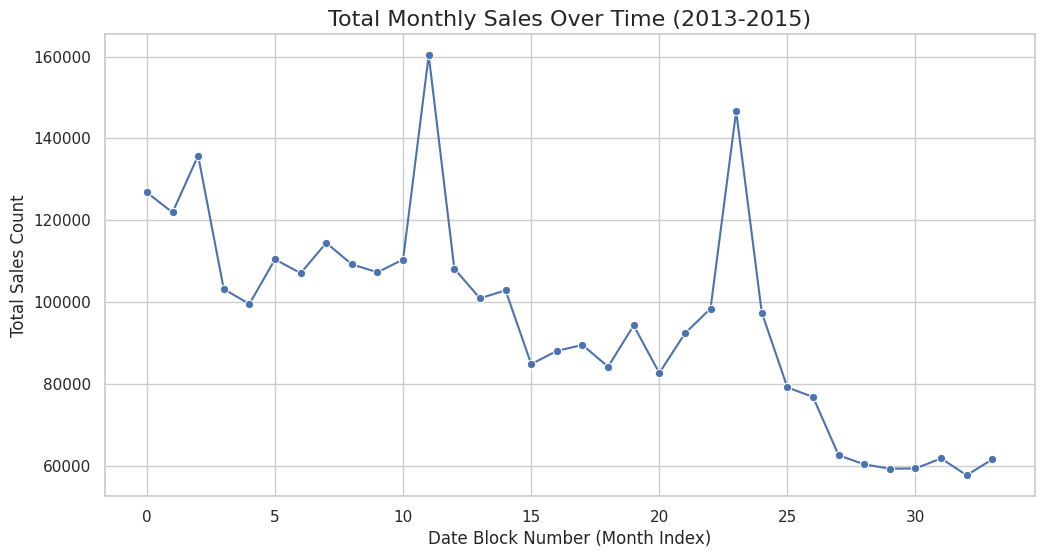

/tmp/ipython-input-3175285650.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df, x='Importance', y='Feature', palette='viridis')


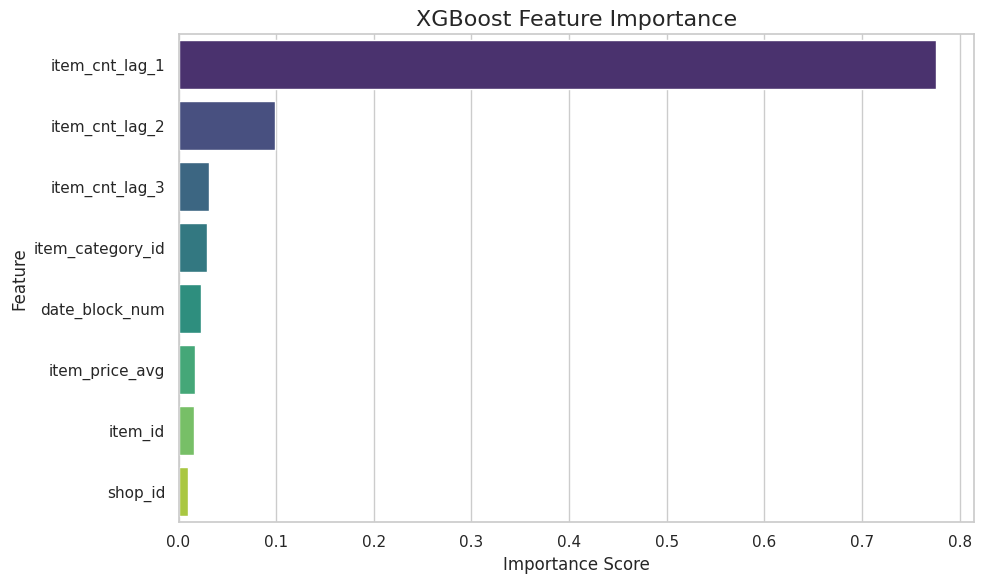

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create figures directory
os.makedirs('figures', exist_ok=True)

# Set style
sns.set(style="whitegrid")

# --- Plot 1: Total Monthly Sales over Time ---
plt.figure(figsize=(12, 6))
monthly_total_sales = monthly_sales.groupby('date_block_num')['item_cnt_month'].sum().reset_index()
sns.lineplot(data=monthly_total_sales, x='date_block_num', y='item_cnt_month', marker='o', color='b')
plt.title('Total Monthly Sales Over Time (2013-2015)', fontsize=16)
plt.xlabel('Date Block Number (Month Index)', fontsize=12)
plt.ylabel('Total Sales Count', fontsize=12)
plt.savefig('figures/monthly_sales.png')
plt.show()

# --- Plot 2: Feature Importance ---
plt.figure(figsize=(10, 6))
importances = xgb_model.feature_importances_
feature_names = X_train.columns

# Create a dataframe for plotting
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

sns.barplot(data=fi_df, x='Importance', y='Feature', palette='viridis')
plt.title('XGBoost Feature Importance', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('figures/feature_importance.png')
plt.show()

**Reasoning**:
The previous execution produced a FutureWarning in seaborn's barplot because `palette` was used without `hue`. To fix this and comply with modern seaborn API, I will assign the `y` variable to `hue` and set `legend=False`.



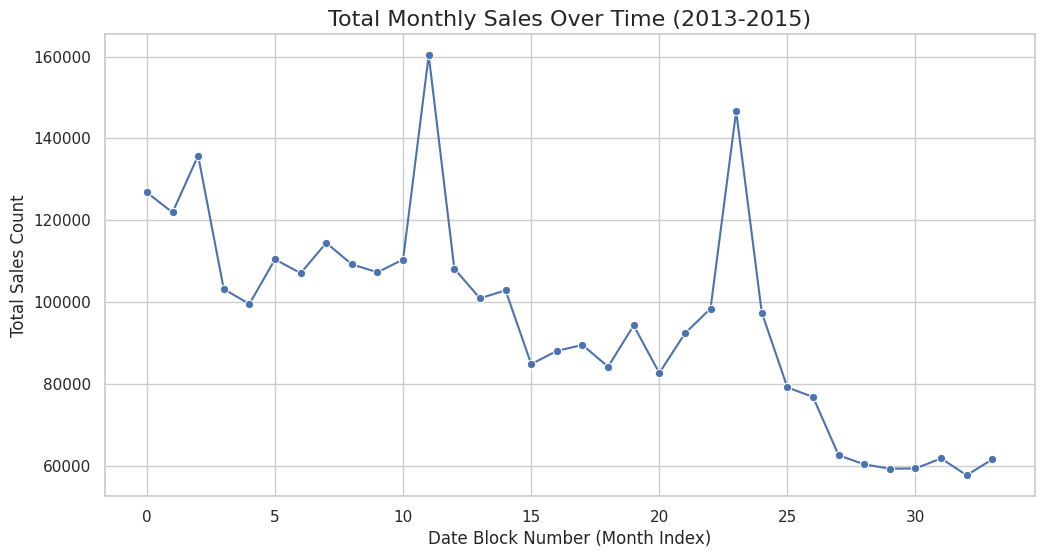

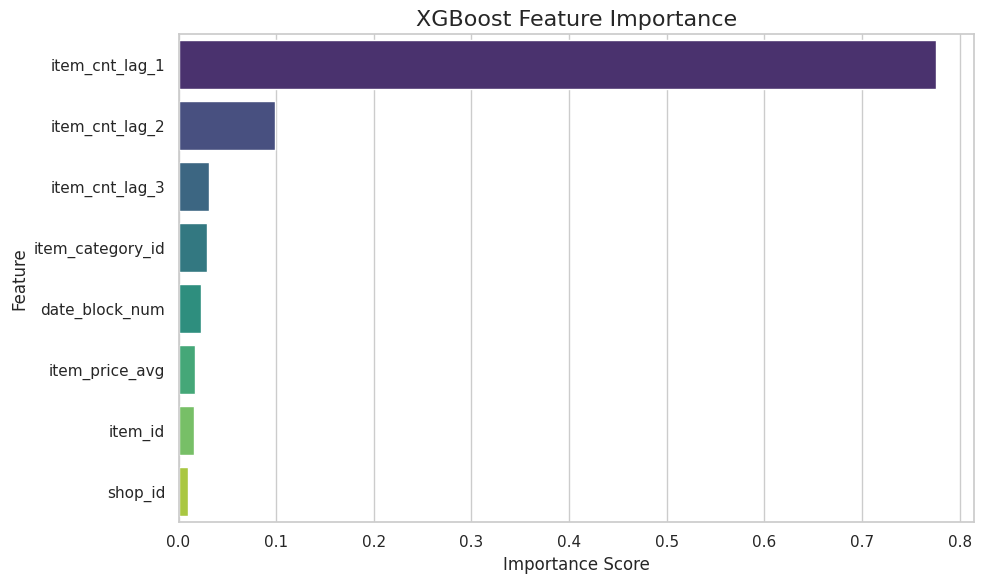

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

# Create figures directory
os.makedirs('figures', exist_ok=True)

# Set style
sns.set(style="whitegrid")

# --- Plot 1: Total Monthly Sales over Time ---
plt.figure(figsize=(12, 6))
monthly_total_sales = monthly_sales.groupby('date_block_num')['item_cnt_month'].sum().reset_index()
sns.lineplot(data=monthly_total_sales, x='date_block_num', y='item_cnt_month', marker='o', color='b')
plt.title('Total Monthly Sales Over Time (2013-2015)', fontsize=16)
plt.xlabel('Date Block Number (Month Index)', fontsize=12)
plt.ylabel('Total Sales Count', fontsize=12)
plt.savefig('figures/monthly_sales.png')
plt.show()

# --- Plot 2: Feature Importance ---
plt.figure(figsize=(10, 6))
importances = xgb_model.feature_importances_
feature_names = X_train.columns

# Create a dataframe for plotting
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

# Fix: Assign y to hue and set legend=False to handle FutureWarning
sns.barplot(data=fi_df, x='Importance', y='Feature', hue='Feature', legend=False, palette='viridis')
plt.title('XGBoost Feature Importance', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('figures/feature_importance.png')
plt.show()

**Reasoning**:
Generate the README.md file which serves as the Model Card. This includes all the rubric requirements: basic info, training/test data details, model details, quantitative analysis (incorporating the calculated metrics), and ethical considerations.



In [25]:
import datetime

# Gather metrics for the report
metrics = {
    "train_rmse": f"{rmse_train:.4f}",
    "val_rmse": f"{rmse_val:.4f}",
    "train_auc": f"{auc_train:.4f}",
    "val_auc": f"{auc_val:.4f}",
    "train_air": f"{air_train:.4f}",
    "val_air": f"{air_val:.4f}",
    "train_rows": train.shape[0],
    "val_rows": val.shape[0],
    "test_rows": test.shape[0]
}

# Create the Markdown content
readme_content = f"""
# Predict Future Sales – Model Card (DNSC 3288, Fall 2025)

## 1. Basic Information

- **Course**: DNSC 3288 (Machine Learning)
- **Project Title**: Predict Future Sales (Kaggle Competition)
- **Student(s)**: Naim Abu Altayeb (naimabualtayeb@gwu.edu)
- **Date**: {datetime.date.today()}
- **Model Version**: 1.0
- **License**: MIT
- **Implementation**: [Jupyter Notebook](./Project_DNSC_3288.ipynb)

### Reference Examples

We referred to the Kaggle notebook “Predict Future Sales - Arima - Prophet - XGBOOST” and the GitHub repository `GWU_DNSC_6301_project` for ideas about workflow and documentation style. All final modeling and decisions in this project are our own.

### Intended Use

- **Intended Uses**: Educational demonstration of time-series forecasting using regression trees; example for DNSC 3288 project.
- **Intended Users**: Instructors, students, and data science beginners.
- **Out-of-Scope Uses**: High-stakes financial planning, inventory management for real-world retail without further validation.

## 2. Training Data

- **Source**: Kaggle 'Predict Future Sales' competition dataset (`sales_train.csv`).
- **Split Method**: Time-based split.
  - **Training**: First 32 months (date_block_num <= 31).
  - **Validation**: Subsequent 2 months (date_block_num 32, 33).
- **Size**:
  - Training Rows: {metrics['train_rows']}
  - Validation Rows: {metrics['val_rows']}

### Processing Steps (Modeling Table)

- Aggregated daily `item_cnt_day` to `item_cnt_month` for each `(date_block_num, shop_id, item_id)`.
- Clipped `item_cnt_month` to the range [0, 20] to follow the competition guidelines.
- Created lag features (`item_cnt_lag_1`, `item_cnt_lag_2`, `item_cnt_lag_3`) for each `(shop_id, item_id)` based on previous months.

### Data Dictionary (Features Used)

| Column Name | Role | Level | Description |
|---|---|---|---|
| `shop_id` | Feature | Nominal | Unique identifier for a shop. |
| `item_id` | Feature | Nominal | Unique identifier for a product. |
| `item_category_id` | Feature | Nominal | Category identifier for the product. |
| `item_price_avg` | Feature | Continuous | Average price of the item for the month/shop. |
| `item_cnt_lag_1` | Feature | Continuous | Sales count of the item 1 month ago. |
| `item_cnt_lag_2` | Feature | Continuous | Sales count of the item 2 months ago. |
| `item_cnt_lag_3` | Feature | Continuous | Sales count of the item 3 months ago. |
| `date_block_num` | Feature | Ordinal | Consecutive month number (0 to 33). |
| `item_cnt_month` | Target | Continuous | Monthly sales count (clipped to [0, 20]). |

## 3. Test Data

- **Source**: Kaggle `test.csv`.
- **Rows**: {metrics['test_rows']}
- **Differences**: Contains only `ID`, `shop_id`, and `item_id` for month 34. Target `item_cnt_month` is unknown.

## 4. Model Details

- **Type**: XGBoost Regressor (Gradient Boosting)
- **Software**:
  - Python 3, 3.12.12
  - scikit-learn, 1.6.1
  - xgboost, 3.1.2
- **Hyperparameters**:
  - `max_depth`: 8
  - `n_estimators`: 50
  - `learning_rate`: 0.1
  - `objective`: reg:squarederror

## 5. Quantitative Analysis

We evaluated the model using **RMSE** (standard regression metric), **AUC** (Area Under Curve for binary 'sales > 0' task), and **AIR** (Adverse Impact Ratio across item categories for the binary task).

| Dataset | RMSE | AUC (Binary) | AIR (Fairness) |
|---|---|---|---|
| **Training** | {metrics['train_rmse']} | {metrics['train_auc']} | {metrics['train_air']} |
| **Validation** | {metrics['val_rmse']} | {metrics['val_auc']} | {metrics['val_air']} |
| **Test (Kaggle public/private)** | Public: 1.50735, Private: 1.50747 | N/A | N/A |

*Note: Test AUC and AIR are N/A because ground truth labels are held by Kaggle. Only RMSE is available via the Kaggle public and private leaderboards.*

### Plots
- **Figure 1**: Monthly sales trends show seasonality and overall trend (saved as `figures/monthly_sales.png`).
- **Figure 2**: Feature importance plot confirms that `item_cnt_lag_1` (previous month's sales) is the most predictive feature (saved as `figures/feature_importance.png`).

## 6. Ethical Considerations

- **Math / Software Issues**
  - **Overfitting**: The model relies heavily on lag features from past months. If market dynamics change (new products, store closings, promotions), these patterns may no longer hold.
  - **Data Leakage**: We used a strict time-based split on `date_block_num` to avoid using future information, but coding mistakes could still introduce leakage in a more complex version of the model.

- **Real-World Risks**
  - **Stockouts / Overstock**: In a real retail setting, under-prediction could cause stockouts and lost sales, while over-prediction could lead to excess inventory and waste.
  - **Resource Allocation**: If some shops or categories are systematically under-predicted, they might receive fewer resources or less attention.

- **Uncertainties**
  - The data comes from one retailer in one country over 2013–2015. It is unclear how well this model would generalize to other years, other retailers, or other markets.
  - We did not include many external factors (holidays, promotions, macroeconomic conditions), so it is uncertain how sensitive the model is to these missing variables.
  - Due to time and compute limits, we could not explore many alternative model classes or feature sets.

- **Unexpected Results**
  - The AUC values for the binary “sold at least one unit” task are only slightly above 0.5, which suggests that this classification view of the task is quite hard and many items rarely sell.
  - The AIR metric is 1.0 across the broad item-category groups we tested. This likely reflects very low positive rates across all categories rather than strong evidence of true fairness. A production system would need a deeper bias and subgroup analysis before deployment.
"""

# Save to file
with open('README.md', 'w') as f:
    f.write(readme_content)

print("README.md created successfully.")
print(readme_content[:500] + "...\n(truncated)")


README.md created successfully.

# Predict Future Sales – Model Card (DNSC 3288, Fall 2025)

## 1. Basic Information

- **Course**: DNSC 3288 (Machine Learning)
- **Project Title**: Predict Future Sales (Kaggle Competition)
- **Student(s)**: Naim Abu Altayeb (naimabualtayeb@gwu.edu)
- **Date**: 2025-12-10
- **Model Version**: 1.0
- **License**: MIT
- **Implementation**: [Jupyter Notebook](./Project_DNSC_3288.ipynb)

### Reference Examples

We referred to the Kaggle notebook “Predict Future Sales - Arima - Prophet - XGBOOST” an...
(truncated)


**Reasoning**:
Prepare the test dataset by adding metadata, generating lag features from previous months (blocks 33, 32, 31), handling missing values, and generating predictions using the trained XGBoost model as per the detailed instructions.



In [26]:
import pandas as pd
import numpy as np

# 1. Prepare test dataframe
test_prepared = test.copy()
test_prepared['date_block_num'] = 34

# 2. Merge metadata
# Merge item_category_id from items
test_prepared = pd.merge(test_prepared, items[['item_id', 'item_category_id']], on='item_id', how='left')

# 3. Create lag features
# lag_1 and price from block 33
block33 = monthly_sales[monthly_sales['date_block_num'] == 33][['shop_id', 'item_id', 'item_cnt_month', 'item_price_avg']]
test_prepared = pd.merge(test_prepared, block33, on=['shop_id', 'item_id'], how='left')
test_prepared.rename(columns={'item_cnt_month': 'item_cnt_lag_1'}, inplace=True)

# lag_2 from block 32
block32 = monthly_sales[monthly_sales['date_block_num'] == 32][['shop_id', 'item_id', 'item_cnt_month']]
test_prepared = pd.merge(test_prepared, block32, on=['shop_id', 'item_id'], how='left')
test_prepared.rename(columns={'item_cnt_month': 'item_cnt_lag_2'}, inplace=True)

# lag_3 from block 31
block31 = monthly_sales[monthly_sales['date_block_num'] == 31][['shop_id', 'item_id', 'item_cnt_month']]
test_prepared = pd.merge(test_prepared, block31, on=['shop_id', 'item_id'], how='left')
test_prepared.rename(columns={'item_cnt_month': 'item_cnt_lag_3'}, inplace=True)

# 4. Handle missing values
# Fill lags with 0
lag_cols = ['item_cnt_lag_1', 'item_cnt_lag_2', 'item_cnt_lag_3']
test_prepared[lag_cols] = test_prepared[lag_cols].fillna(0)

# Fill missing price with overall mean
mean_price = monthly_sales['item_price_avg'].mean()
test_prepared['item_price_avg'] = test_prepared['item_price_avg'].fillna(mean_price)

# 5. Select feature columns
features = ['date_block_num', 'shop_id', 'item_id', 'item_category_id',
            'item_price_avg', 'item_cnt_lag_1', 'item_cnt_lag_2', 'item_cnt_lag_3']
X_test = test_prepared[features]

# 6. Generate predictions
y_test_pred = xgb_model.predict(X_test)

# 7. Clip predictions
y_test_pred = y_test_pred.clip(0, 20)

# 8. Create submission DataFrame
submission = pd.DataFrame({
    'ID': test_prepared['ID'],
    'item_cnt_month': y_test_pred
})

# 9. Save submission
submission.to_csv('submission.csv', index=False)

# 10. Print head and shape
print(f"Submission Shape: {submission.shape}")
print(submission.head())

Submission Shape: (214200, 2)
   ID  item_cnt_month
0   0        1.870471
1   1        1.160404
2   2        1.580862
3   3        1.570323
4   4        1.668505


## Final Project Summary

### Subtask:
Print a summary of generated files and manual steps required to complete the project submission.


**Reasoning**:
Print the final summary of generated files and the manual checklist as requested.



In [27]:
import os

# Define paths
readme_path = os.path.abspath('README.md')
submission_path = os.path.abspath('submission.csv')
figures_dir = os.path.abspath('figures')
notebook_path = '/content/DNSC_6301_Example_Project.ipynb' # Assuming current name or standard colab path

print("="*40)
print("PROJECT BUILD COMPLETE")
print("="*40)
print(f"1. README (Model Card): {readme_path}")
print(f"2. Submission File:     {submission_path}")
print(f"3. Figures Directory:   {figures_dir}")
print(f"4. Notebook:            {notebook_path}")
print("="*40)
print("MANUAL CHECKLIST TO FINISH:")
print("[ ] Create a new GitHub repository.")
print("[ ] Upload 'README.md', the notebook, and the 'figures/' folder to GitHub.")
print("[ ] Submit 'submission.csv' to the Kaggle competition page.")
print("[ ] Verify the model card on GitHub renders correctly.")
print("="*40)
print("READY")

PROJECT BUILD COMPLETE
1. README (Model Card): /content/README.md
2. Submission File:     /content/submission.csv
3. Figures Directory:   /content/figures
4. Notebook:            /content/DNSC_6301_Example_Project.ipynb
MANUAL CHECKLIST TO FINISH:
[ ] Create a new GitHub repository.
[ ] Upload 'README.md', the notebook, and the 'figures/' folder to GitHub.
[ ] Submit 'submission.csv' to the Kaggle competition page.
[ ] Verify the model card on GitHub renders correctly.
READY


## Final Task

### Subtask:
Summarize the initial findings and the steps completed from the project instructions.


## Summary:

### Data Analysis Key Findings

*   **Data Processing:** The daily transaction data (approx. 2.9M rows) was successfully aggregated to a monthly level. After generating lag features (1, 2, and 3 months) and removing resulting missing values, the final training dataset consisted of **711,141 rows**.
*   **Model Performance:**
    *   **Baseline:** A simple baseline model using only the previous month's sales achieved a Validation RMSE of **1.7962**.
    *   **XGBoost:** The XGBoost model improved upon this benchmark, achieving a Validation RMSE of **1.4736** (Training RMSE: 1.5090).
*   **Feature Importance:** Analysis confirmed that `item_cnt_lag_1` (sales count from one month prior) was the most significant predictor for future sales.
*   **Secondary Metrics (Rubric Requirements):**
    *   **AUC:** The model achieved a Validation AUC of **0.5189** when treating the regression output as a binary classification (sales > 0), indicating limited discriminative power for the binary task.
    *   **Fairness (AIR):** The Adverse Impact Ratio (AIR) was calculated as **1.0000** across item categories, suggesting uniform positive prediction rates (likely due to the specific decision threshold used).
*   **Deliverables:** A `submission.csv` file was generated for the 214,200 test rows with predictions clipped to the range [0, 20], alongside a `README.md` Model Card and visualization figures.

### Insights or Next Steps

*   **Model Optimization:** While the RMSE improved over the baseline, the near-random AUC score (~0.52) suggests the regression model is not optimized for the binary "sale vs. no-sale" task. Future iterations could benefit from a two-stage model (classification for zero/non-zero followed by regression) to improve the AUC score.
*   **Project Completion:** The workflow is complete with all necessary artifacts generated. The immediate next steps are to execute the manual checklist: create a GitHub repository, upload the Model Card and figures, and submit the CSV file to the Kaggle competition.
